# AG-CNN For Bone Age Prediction

In [ ]:
!sudo apt-get install unrar
!pip install visualkeras

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 24.4 MB/s eta 0:00:00


In [ ]:
import cv2
import PIL
from PIL import Image
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from sklearn.feature_extraction.image import extract_patches_2d #
from skimage.measure import label
from IPython.display import display
import tensorflow as tf
import visualkeras
from tensorflow.keras import layers, Model
from keras.applications import ResNet50
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.utils import plot_model, Sequence, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Dense, GlobalAveragePooling2D, concatenate, Input, Dropout, Rescaling, GlobalMaxPooling2D, Flatten, Lambda
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.metrics import mean_absolute_error
from keras.optimizers.schedules import PolynomialDecay

In [ ]:
image_size = (500, 500)
batch_size = 8
n_epochs = 16

## Dataset: Preprocessing and Dataloaders With Data Augmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Copy the file from Google Drive to Colab
!cp '/content/drive/MyDrive/Resized_Dataset_500_500.rar' '/content/'
#!cp '/content/drive/MyDrive/Resized_Dataset_240_240.rar' '/content/'

# Unzip the .rar file
!unrar x "Resized_Dataset_500_500.rar"
#!unrar x "Resized_Dataset_240_240.rar"

Output streaming troncato alle ultime 5000 righe.
Extracting  Resized_Bone_Age_Training_Set_500_500/Resized_Training_Set_Images/6253.png      63%  OK 
Extracting  Resized_Bone_Age_Training_Set_500_500/Resized_Training_Set_Images/6254.png      63%  OK 
Extracting  Resized_Bone_Age_Training_Set_500_500/Resized_Training_Set_Images/6255.png      63%  OK 
Extracting  Resized_Bone_Age_Training_Set_500_500/Resized_Training_Set_Images/6256.png      63%  OK 
Extracting  Resized_Bone_Age_Training_Set_500_500/Resized_Training_Set_Images/6257.png      63%  OK 
Extracting  Resized_Bone_Age_Training_Set_500_500/Resized_Training_Set_Images/6258.png      63%  OK 
Extracting  Resized_Bone_Age_Training_Set_500_500/Resized_Training_Set_Images/6259.png      63%  OK 
Extracting  Resized_Bone_Age_Training_Set_500_500/Resized_Training_Set_Images/6260.png      63%  OK 
Extracting  Resized_Bone_Age_Training_Set_500_500/Resized_Training_Set

<class 'PIL.PngImagePlugin.PngImageFile'>
(500, 500)


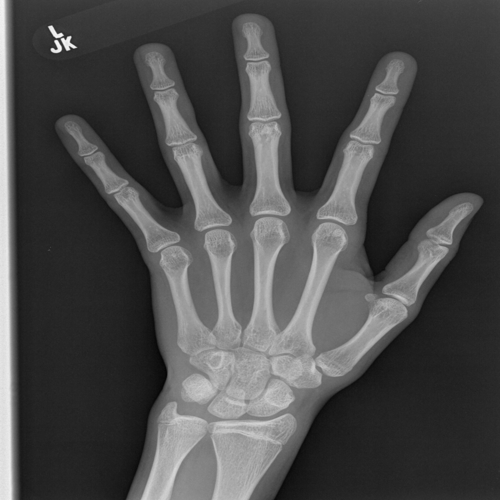

In [ ]:
train_imgs_path = os.path.join('Resized_Bone_Age_Training_Set_500_500', 'Resized_Training_Set_Images')
valid_imgs_path = os.path.join('Resized_Bone_Age_Validation_Set_500_500', 'Resized_Validation_Set_Images')
test_imgs_path = os.path.join('Resized_Bone_Age_Test_Set_500_500', 'Resized_Test_Set_Images')
#train_imgs_path = os.path.join('Resized_Bone_Age_Training_Set_240_240', 'Resized_Training_Set_Images')
#valid_imgs_path = os.path.join('Resized_Bone_Age_Validation_Set_240_240', 'Resized_Validation_Set_Images')
#test_imgs_path = os.path.join('Resized_Bone_Age_Test_Set_240_240', 'Resized_Test_Set_Images')

# Example
ex_img_path = os.path.join(train_imgs_path, '1377.png')
ex_img = Image.open(ex_img_path)
print(type(ex_img))
img_array = np.array(ex_img)
print(img_array.shape)

ex_img

In [ ]:
def preprocessing(dataset_type, csv_path, imgs_path, print_info = False, plot_graphs = False):
    # Read the CSV file into a DataFrame
    if dataset_type == 'Training' or dataset_type == 'Validation':
        df = pd.read_csv(csv_path)
    elif dataset_type == 'Test':
        df = pd.read_excel(csv_path)

    # Dataframe manipulation
    if dataset_type == 'Validation':
        new_column_names = {'Image ID': 'id', 'Bone Age (months)': 'boneage'}
        df.rename(columns=new_column_names, inplace=True)
    if dataset_type == 'Test':
        new_column_names = {'Case ID': 'id', 'Ground truth bone age (months)': 'boneage', 'Sex': 'male'}
        df.rename(columns=new_column_names, inplace=True)
    df['path'] = df['id'].astype(str).map(lambda x: os.path.join(imgs_path, '{}.png'.format(x)))
    df['exists'] = df['path'].map(os.path.exists)
    #print(df['exists'].sum(), 'images found of', df.shape[0], 'total\n')
    boneage_mean = df['boneage'].mean()
    boneage_std = df['boneage'].std()
    df['normalized_boneage'] = df['boneage'].map(lambda x: (x - boneage_mean) / boneage_std)
    #age_df.dropna(inplace = True)
    if dataset_type == 'Training':
        df['male'] = df['male'].astype(int) #converts true or false into 1 and 0
        df['male'] = df['male'].replace(to_replace=0, value=-1)
    elif dataset_type == 'Validation':
        df['male'] = df['male'].map({"VERO": 1, "FALSO": 0})                                              #
        df['male'] = df['male'].astype(int) #converrts true or false into 1 and 0
        df['male'] = df['male'].replace(to_replace=0, value=-1)
    elif dataset_type == 'Test':
        df['male'] = df['male'].map({"M": 1, "F": -1})
    df.sort_values('id')

    # Print useful info before re-distribution
    if print_info:
        print('{} dataset info before re-distribution'.format(dataset_type))
        print(df.head())
        print('\nData shape: ', df.shape)
        print("\nMax {} boneage:".format(dataset_type), df['boneage'].max())
        print("Min {} boneage:".format(dataset_type), df['boneage'].min())
        print("\nMean {} boneage:".format(dataset_type), boneage_mean)
        print("Standard deviation {} boneage:".format(dataset_type), boneage_std, "\n\n")

    # Histograms of data distribution before re-distribution
    if plot_graphs:
        fig1, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
        fig1.suptitle('{} Dataset Histograms Before Preprocessing'.format(dataset_type))
        ax1.hist(df['boneage'], color = 'darkblue')
        ax2.hist(df['male'], color = 'firebrick')
        ax1.set_title('Bone Age Distribution')
        ax1.set_xlabel('Bone Age')
        ax1.set_ylabel('Frequency')
        ax2.set_title('Male Distribution')
        ax2.set_xlabel('Sex')
        ax2.set_ylabel('Frequency')
        ax1.grid()
        ax2.grid()
        #plt.savefig('/content/drive/MyDrive/Histo_Before_Preprocessing_{}.pdf'.format(dataset_type), bbox_inches = 'tight')

    if dataset_type == 'Training': N_samples = 500
    elif dataset_type == 'Validation': N_samples = 50
    elif dataset_type == 'Test': N_samples = 8

    # Data re-distribution
    df['boneage_category'] = pd.cut(df['boneage'], 10)
    df = df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(N_samples, replace = True)).reset_index(drop=True)
    boneage_mean = df['boneage'].mean()
    boneage_std = df['boneage'].std()
    df['normalized_boneage'] = df['boneage'].map(lambda x: (x - boneage_mean) / boneage_std)

    # Print useful info after re-distribution
    if print_info:
        print('{} dataset info after re-distribution'.format(dataset_type))
        print(df.head())
        print('\nData shape: ', df.shape)
        print("\nMax {} boneage:".format(dataset_type), df['boneage'].max())
        print("Min {} boneage:".format(dataset_type), df['boneage'].min())
        print("\nMean {} boneage:".format(dataset_type), boneage_mean)
        print("Standard deviation {} boneage:".format(dataset_type), boneage_std, "\n\n")

    # Histograms of data distribution after re-distribution
    if plot_graphs:
        fig2, (ax3, ax4) = plt.subplots(1, 2, figsize = (10, 4))
        fig2.suptitle('{} Dataset Histograms After Preprocessing'.format(dataset_type))
        ax3.hist(df['boneage'], color = 'darkblue')
        ax4.hist(df['male'], color = 'firebrick')
        ax3.set_title('Bone Age Distribution')
        ax3.set_xlabel('Bone Age')
        ax3.set_ylabel('Frequency')
        ax4.set_title('Male Distribution')
        ax4.set_xlabel('Sex')
        ax4.set_ylabel('Frequency')
        ax3.grid()
        ax4.grid()
        #plt.savefig('/content/drive/MyDrive/Histo_After_Preprocessing_{}.pdf'.format(dataset_type), bbox_inches = 'tight')

    return df, boneage_mean, boneage_std

In [ ]:
train_df, train_boneage_mean, train_boneage_std = preprocessing('Training', '/content/drive/MyDrive/Ground_Truth_Training.csv', train_imgs_path)
valid_df, valid_boneage_mean, valid_boneage_std = preprocessing('Validation', '/content/drive/MyDrive/Ground_Truth_Validation.csv', valid_imgs_path)
test_df, test_boneage_mean, test_boneage_std = preprocessing('Test', '/content/drive/MyDrive/Ground_Truth_Test.xlsx', test_imgs_path)

In [ ]:
!cp '/content/drive/MyDrive/Dataloaders.py' '/content/'

In [ ]:
from Dataloaders import *

In [ ]:
train_generator = CustomImgGen_1ch(train_df, batch_size, img_augmentation_params, 'Training')
val_generator = CustomImgGen_1ch(valid_df, batch_size, img_augmentation_params, 'Validation')
test_generator = CustomImgGen_1ch(test_df, batch_size, img_augmentation_params, 'Test')

## AG-CNN Architecture

In [ ]:
#Mae months metric
def mae_months(in_gt, in_pred, dataset_type='Training'):
    if dataset_type == 'Training':
        return mean_absolute_error(train_boneage_mean+train_boneage_std*in_gt, train_boneage_mean+train_boneage_std*in_pred)
    elif dataset_type == 'Validation':
        return mean_absolute_error(valid_boneage_mean+valid_boneage_std*in_gt, valid_boneage_mean+valid_boneage_std*in_pred)
    elif dataset_type == 'Test':
        return mean_absolute_error(test_boneage_mean+test_boneage_std*in_gt, test_boneage_mean+test_boneage_std*in_pred)

In [ ]:
def identity_block(x, filters, kernel_size, name=''):
    f1, f2, f3 = filters

    x_shortcut = x

    x = layers.Conv2D(f1, (1, 1), padding='valid', kernel_initializer='HeUniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(f2, kernel_size, padding='same', kernel_initializer='HeUniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(f3, (1, 1), padding='valid', kernel_initializer='HeUniform')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, x_shortcut])
    if name == '':
        x = layers.LeakyReLU()(x)
    else:
        x = layers.LeakyReLU(name=name)(x)

    return x

def convolutional_block(x, filters, kernel_size, strides=(2, 2)):
    f1, f2, f3 = filters

    x_shortcut = x

    x = layers.Conv2D(f1, (1, 1), strides=strides, padding='valid', kernel_initializer='HeUniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(f2, kernel_size, padding='same', kernel_initializer='HeUniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(f3, (1, 1), padding='valid', kernel_initializer='HeUniform')(x)
    x = layers.BatchNormalization()(x)

    x_shortcut = layers.Conv2D(f3, (1, 1), strides=strides, padding='valid', kernel_initializer='HeUniform')(x_shortcut)
    x_shortcut = layers.BatchNormalization()(x_shortcut)

    x = layers.add([x, x_shortcut])
    x = layers.LeakyReLU()(x)

    return x

def ResNet_based_branch(input_shape, batch_size, branch_name):
    images_input = Input(shape=input_shape, batch_size = batch_size, name='Images')
    sex_input = Input(shape = (1), batch_size = batch_size, name='Sex')

    x = layers.ZeroPadding2D((3, 3))(images_input)

    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer='HeUniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = convolutional_block(x, [64, 64, 256], 3, strides=(1, 1))
    x = identity_block(x, [64, 64, 256], 3)
    x = identity_block(x, [64, 64, 256], 3)

    x = convolutional_block(x, [128, 128, 512], 3)
    x = identity_block(x, [128, 128, 512], 3)
    x = identity_block(x, [128, 128, 512], 3)
    x = identity_block(x, [128, 128, 512], 3)

    x = convolutional_block(x, [256, 256, 1024], 3)
    x = identity_block(x, [256, 256, 1024], 3)
    x = identity_block(x, [256, 256, 1024], 3)
    x = identity_block(x, [256, 256, 1024], 3)
    x = identity_block(x, [256, 256, 1024], 3)

    x = convolutional_block(x, [512, 512, 2048], 3)
    x = identity_block(x, [512, 512, 2048], 3)
    out_features = identity_block(x, [512, 512, 2048], 3, name='Feature_Map_{}'.format(branch_name))

    out_pooling = layers.GlobalAveragePooling2D(name = 'Average_Pooling_{}'.format(branch_name))(out_features)
    x = layers.Dense(256, activation='leaky_relu', kernel_initializer='HeUniform')(out_pooling)
    x = layers.Dropout(0.5)(x)
    out_final = layers.Dense(1, activation='linear', name = 'Last_Layer_{}'.format(branch_name))(x)

    model = Model(inputs=images_input, outputs=[out_final, out_features, out_pooling], name='ResNet_Based_{}'.format(branch_name))

    return model

def Fusion_branch(input_shape, batch_size):
    global_pool_input = Input(shape = (input_shape), batch_size = batch_size, name = 'Global_Branch_Pool_Output')
    local_pool_input = Input(shape = (input_shape), batch_size = batch_size, name = 'Local_Branch_Pool_Output')
    sex_input = Input(shape = (1), batch_size = batch_size, name='Sex')

    fusion_input = layers.Concatenate()([global_pool_input, local_pool_input, sex_input])

    x = layers.Dense(256, activation='leaky_relu', kernel_initializer='HeUniform')(fusion_input)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='leaky_relu', kernel_initializer='HeUniform')(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(1, activation='linear')(x)

    model = Model(inputs=[global_pool_input, local_pool_input, sex_input], outputs=output_layer)

    return model

In [ ]:
# Find attention region with maximum connected area
def SelectMaxConnect(heatmap):
    labeled_img, num = label(heatmap, connectivity=2, background=0, return_num=True)
    max_label = 0
    max_num = 0
    for i in range(1, num+1):
        if np.sum(labeled_img == i) > max_num:
            max_num = np.sum(labeled_img == i)
            max_label = i
    lcc = (labeled_img == max_label)
    if max_num == 0:
       lcc = (labeled_img == -1)
    lcc = lcc + 0
    return lcc

# Find attention image
def Attention_Mask_Inference(original_image, feature_map, size_upsample = image_size, batch_size = batch_size):
    bs, h, w, nc = feature_map.shape
    attention_masks_batch = []

    for i in range(0, bs):
        feature = feature_map[i]
        cam = feature.reshape((h*w, nc))
        cam = cam.sum(axis=1)
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)

        _, heatmap_bin = cv2.threshold(cv2.resize(cam_img, size_upsample), 0 , 255 , cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        heatmap_maxconn = SelectMaxConnect(heatmap_bin)
        heatmap_mask = heatmap_bin * heatmap_maxconn

        ind = np.argwhere(heatmap_mask != 0)
        minh = min(ind[:,0])
        minw = min(ind[:,1])
        maxh = max(ind[:,0])
        maxw = max(ind[:,1])

        image = original_image[i]

        image_crop = image[minh:maxh, minw:maxw] * 256 # because image was normalized before
        image_crop = cv2.resize(image_crop, size_upsample)
        image_crop -= 128
        image_crop /= 128

        attention_masks_batch.append(image_crop)

    attention_masks_batch = np.array(attention_masks_batch)

    return attention_masks_batch

In [ ]:
global_branch = ResNet_based_branch((image_size[0], image_size[1], 1), batch_size, 'Global_Branch')
local_branch = ResNet_based_branch((image_size[0], image_size[1], 1), batch_size, 'Local_Branch')
fusion_branch = Fusion_branch(2048, batch_size)

In [ ]:
global_branch.summary()

Model: "ResNet_Based_Global_Branch"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Images (InputLayer)         [(8, 500, 500, 1)]           0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (8, 506, 506, 1)             0         ['Images[0][0]']              
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (8, 250, 250, 64)            3200      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (8, 250, 250, 64)            256       ['con

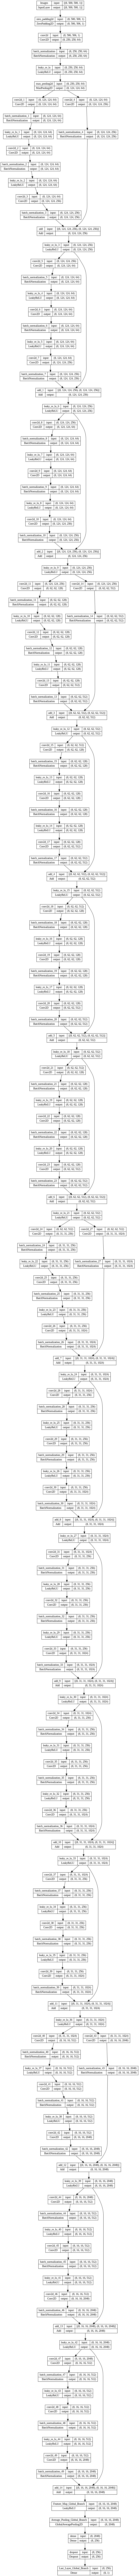

In [ ]:
plot_model(global_branch, "global_branch_plot.png", show_shapes=True)

In [ ]:
local_branch.summary()

Model: "ResNet_Based_Local_Branch"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Images (InputLayer)         [(8, 500, 500, 1)]           0         []                            
                                                                                                  
 zero_padding2d_1 (ZeroPadd  (8, 506, 506, 1)             0         ['Images[0][0]']              
 ing2D)                                                                                           
                                                                                                  
 conv2d_50 (Conv2D)          (8, 250, 250, 64)            3200      ['zero_padding2d_1[0][0]']    
                                                                                                  
 batch_normalization_50 (Ba  (8, 250, 250, 64)            256       ['conv

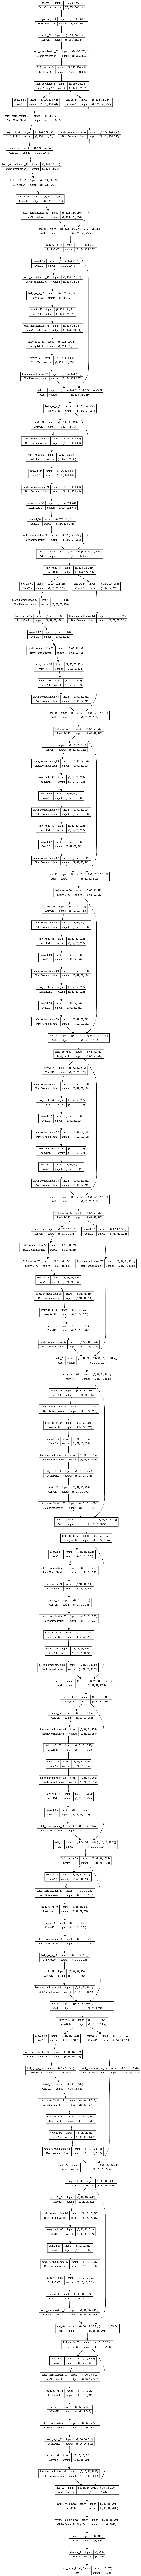

In [ ]:
plot_model(local_branch, "local_branch_plot.png", show_shapes=True)

In [ ]:
fusion_branch.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Global_Branch_Pool_Output   [(8, 2048)]                  0         []                            
 (InputLayer)                                                                                     
                                                                                                  
 Local_Branch_Pool_Output (  [(8, 2048)]                  0         []                            
 InputLayer)                                                                                      
                                                                                                  
 Sex (InputLayer)            [(8, 1)]                     0         []                            
                                                                                              

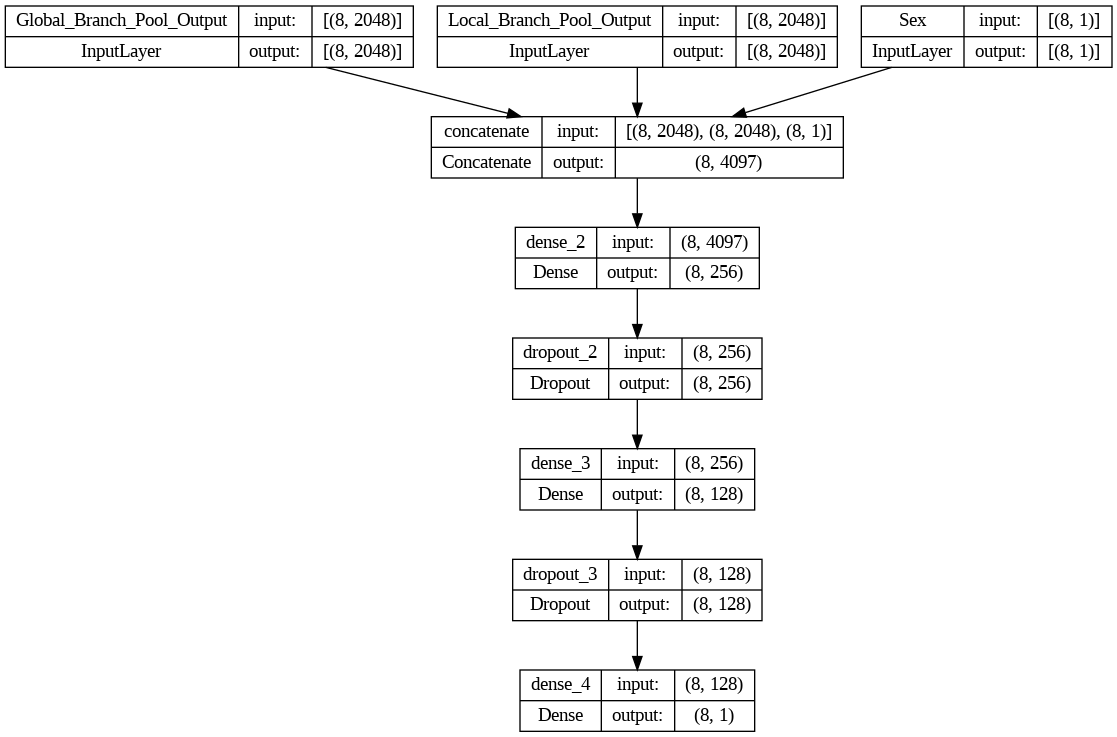

In [ ]:
plot_model(fusion_branch, "fusion_branch_plot.png", show_shapes=True)

# Training

In [ ]:
# Run only to load a previously trained model and continue the training
#!cp '/content/drive/MyDrive/Global_Branch_Best.keras' '/content/'
#!cp '/content/drive/MyDrive/Local_Branch_Best.keras' '/content/'
#!cp '/content/drive/MyDrive/Fusion_Branch_Best.keras' '/content/'

In [ ]:
# Run only to load a previously trained model and continue the training
#global_branch = tf.keras.models.load_model('/content/Global_Branch_Best.keras')
#local_branch = tf.keras.models.load_model('/content/Local_Branch_Best.keras')
#fusion_branch = tf.keras.models.load_model('/content/Fusion_Branch_Best.keras')

In [ ]:
# Instantiate one optimizer for each branch.
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
l_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
f_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Instantiate a loss function.
loss_fn = tf.keras.losses.MeanSquaredError()

# Best weights path
g_best_path = "/content/drive/MyDrive/AG_CNN_Models/Global_Branch_Best.keras"
l_best_path = "/content/drive/MyDrive/AG_CNN_Models/Local_Branch_Best.keras"
f_best_path = "/content/drive/MyDrive/AG_CNN_Models/Fusion_Branch_Best.keras"

# Define loss metrics
g_train_loss_metric = tf.keras.metrics.Mean(name='Global_Branch_Training_Loss')
g_valid_loss_metric = tf.keras.metrics.Mean(name='Global_Branch_Validation_Loss')
l_train_loss_metric = tf.keras.metrics.Mean(name='Local_Branch_Training_Loss')
l_valid_loss_metric = tf.keras.metrics.Mean(name='Local_Branch_Validation_Loss')
f_train_loss_metric = tf.keras.metrics.Mean(name='Fusion_Branch_Training_Loss')
f_valid_loss_metric = tf.keras.metrics.Mean(name='Fusion_Branch_Validation_Loss')

# Define mae months metrics
g_train_mae_metric = tf.keras.metrics.Mean(name='Global_Branch_Training_MAE')
g_valid_mae_metric = tf.keras.metrics.Mean(name='Global_Branch_Validation_MAE')
l_train_mae_metric = tf.keras.metrics.Mean(name='Local_Branch_Training_MAE')
l_valid_mae_metric = tf.keras.metrics.Mean(name='Local_Branch_Validation_MAE')
f_train_mae_metric = tf.keras.metrics.Mean(name='Fusion_Branch_Training_MAE')
f_valid_mae_metric = tf.keras.metrics.Mean(name='Fusion_Branch_Validation_MAE')

In [ ]:
# Train step functions for each branch
@tf.function
def g_train_step(original_images, labels):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(global_branch.trainable_variables)
        g_predictions, g_fm_out, g_pool_out  = global_branch(original_images, training=True)
        g_loss = 0.8 * loss_fn(g_predictions, labels)

    gradients = tape.gradient(g_loss, global_branch.trainable_variables)
    g_optimizer.apply_gradients(zip(gradients, global_branch.trainable_variables))

    g_train_loss_metric(g_loss / 0.8)

    g_mae = mae_months(labels, g_predictions, "Training")
    g_train_mae_metric(g_mae)

    return g_fm_out, g_pool_out, g_train_loss_metric.result(), g_train_mae_metric.result()

@tf.function
def l_train_step(attention_images, labels):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(local_branch.trainable_variables)
        l_predictions, _, l_pool_out = local_branch(attention_images, training=True)
        l_loss = 0.1 * loss_fn(l_predictions, labels)

    gradients = tape.gradient(l_loss, local_branch.trainable_variables)
    l_optimizer.apply_gradients(zip(gradients, local_branch.trainable_variables))

    l_train_loss_metric(l_loss / 0.1)

    l_mae = mae_months(labels, l_predictions, "Training")
    l_train_mae_metric(l_mae)

    return l_pool_out, l_train_loss_metric.result(), l_train_mae_metric.result()

@tf.function
def f_train_step(global_pool, local_pool, sex, labels):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(fusion_branch.trainable_variables)
        f_predictions = fusion_branch({'Global_Branch_Pool_Output': global_pool, 'Local_Branch_Pool_Output': local_pool, 'Sex': sex}, training=True)
        f_loss = 0.1 * loss_fn(f_predictions, labels)

    gradients = tape.gradient(f_loss, fusion_branch.trainable_variables)
    f_optimizer.apply_gradients(zip(gradients, fusion_branch.trainable_variables))

    f_train_loss_metric(f_loss / 0.1)

    f_mae = mae_months(labels, f_predictions, "Training")
    f_train_mae_metric(f_mae)

    return f_train_loss_metric.result(), f_train_mae_metric.result()

# Validation step functions for each branch
@tf.function
def g_valid_step(original_images, labels):

    g_val_pred, g_val_fm_out, g_val_pool_out = global_branch(original_images, training=False)

    g_val_loss = loss_fn(g_val_pred, labels)
    g_valid_loss_metric(g_val_loss)

    g_val_mae = mae_months(labels, g_val_pred, "Validation")
    g_valid_mae_metric(g_val_mae)

    return g_val_fm_out, g_val_pool_out, g_valid_loss_metric.result(), g_valid_mae_metric.result()

@tf.function
def l_valid_step(attention_images, labels):

    l_val_pred, _, l_val_pool_out = local_branch(attention_images, training=False)

    l_val_loss = loss_fn(l_val_pred, labels)
    l_valid_loss_metric(l_val_loss)

    l_val_mae = mae_months(labels, l_val_pred, "Validation")
    l_valid_mae_metric(l_val_mae)

    return l_val_pool_out, l_valid_loss_metric.result(), l_valid_mae_metric.result()

@tf.function
def f_valid_step(global_pool, local_pool, sex, labels):

    f_val_pred = fusion_branch({'Global_Branch_Pool_Output': global_pool, 'Local_Branch_Pool_Output': local_pool, 'Sex': sex}, training=False)

    f_val_loss = loss_fn(f_val_pred, labels)
    f_valid_loss_metric(f_val_loss)

    f_val_mae = mae_months(labels, f_val_pred, "Validation")
    f_valid_mae_metric(f_val_mae)

    return f_valid_loss_metric.result(), f_valid_mae_metric.result()

In [ ]:
g_loss_tracker = []
l_loss_tracker = []
f_loss_tracker = []

g_mae_tracker = []
l_mae_tracker = []
f_mae_tracker = []

g_val_loss_tracker = [np.Inf]
l_val_loss_tracker = [np.Inf]
f_val_loss_tracker = [np.Inf]

g_val_mae_tracker = []
l_val_mae_tracker = []
f_val_mae_tracker = []

for epoch in range(1, n_epochs+1):
    # Reset the metrics at the start of the next epoch
    g_train_loss_metric.reset_states()
    l_train_loss_metric.reset_states()
    f_train_loss_metric.reset_states()

    g_valid_loss_metric.reset_states()
    l_valid_loss_metric.reset_states()
    f_valid_loss_metric.reset_states()

    g_train_mae_metric.reset_states()
    l_train_mae_metric.reset_states()
    f_train_mae_metric.reset_states()

    g_valid_mae_metric.reset_states()
    l_valid_mae_metric.reset_states()
    f_valid_mae_metric.reset_states()

    with tqdm.tqdm(train_generator, unit="batch") as tepoch:
        # Training
        for batch_inputs, batch_labels in tepoch:
            tepoch.set_description("Epoch {}/{}".format(epoch, n_epochs))
            g_fm_out, g_pool_out, g_train_loss, g_train_mae = g_train_step(batch_inputs['Images'], batch_labels)
            g_loss_tracker.append(g_train_loss.numpy())
            g_mae_tracker.append(g_train_mae.numpy())
            attention_images = Attention_Mask_Inference(batch_inputs['Images'], g_fm_out.numpy())
            l_pool_out, l_train_loss, l_train_mae = l_train_step(attention_images, batch_labels)
            l_loss_tracker.append(l_train_loss.numpy())
            l_mae_tracker.append(l_train_mae.numpy())
            f_train_loss, f_train_mae = f_train_step(g_pool_out, l_pool_out, batch_inputs['Sex'], batch_labels)
            f_loss_tracker.append(f_train_loss.numpy())
            f_mae_tracker.append(f_train_mae.numpy())
            tepoch.set_postfix(global_loss = g_train_loss.numpy(), global_mae = g_train_mae.numpy(), local_loss = l_train_loss.numpy(), local_mae = l_train_mae.numpy(), fusion_loss = f_train_loss.numpy(), fusion_mae = f_train_mae.numpy())

        # Validation
        for val_inputs, val_labels in val_generator:
            g_val_fm_out, g_val_pool_out, g_val_loss, g_val_mae = g_valid_step(val_inputs['Images'], val_labels)
            attention_images = Attention_Mask_Inference(val_inputs['Images'], g_val_fm_out.numpy())
            l_val_pool_out, l_val_loss, l_val_mae = l_valid_step(attention_images, val_labels)
            f_val_loss, f_val_mae = f_valid_step(g_val_pool_out, l_val_pool_out, val_inputs['Sex'], val_labels)

        g_old_best_val_loss = np.min(g_val_loss_tracker)
        l_old_best_val_loss = np.min(l_val_loss_tracker)
        f_old_best_val_loss = np.min(f_val_loss_tracker)

        g_val_loss_tracker.append(g_val_loss.numpy())
        g_val_mae_tracker.append(g_val_mae.numpy())
        l_val_loss_tracker.append(l_val_loss.numpy())
        l_val_mae_tracker.append(l_val_mae.numpy())
        f_val_loss_tracker.append(f_val_loss.numpy())
        f_val_mae_tracker.append(f_val_mae.numpy())

        print('Global_Branch_Val_Loss: {}    Local_branch_Val_Loss: {}    Fusion_Branch_Val_Loss: {}'.format(round(g_val_loss.numpy(), 3), round(l_val_loss.numpy(), 3), round(f_val_loss.numpy(), 3)))
        print('Global_Branch_Val_mae: {}    Local_Branch_Val_mae: {}    Fusion_Branch_Val_mae: {}'.format(round(g_val_mae.numpy(), 3), round(l_val_mae.numpy(), 3), round(f_val_mae.numpy(), 3)))

        # Saving model with lowest fusion branch validation loss
        if f_val_loss.numpy() <= f_old_best_val_loss:
            print('Fusion_Branch_Val_Loss improved from {} to {}. Saving the model on Colab.\n'.format(round(f_old_best_val_loss, 3), round(f_val_loss.numpy(), 3)))
            global_branch.save(g_best_path)
            global_branch.save('Global_Branch_Best.keras')
            local_branch.save(l_best_path)
            local_branch.save('Local_Branch_Best.keras')
            fusion_branch.save(f_best_path)
            fusion_branch.save('Fusion_Branch_Best.keras')
        else:
            print('Fusion_Branch_Val_Loss did not improve from {}\n'.format(round(f_old_best_val_loss, 3)))

Epoch 1/16: 100%|██████████| 1250/1250 [28:41<00:00,  1.38s/batch, fusion_loss=1.24, fusion_mae=63.5, global_loss=1, global_mae=66.5, local_loss=1.06, local_mae=64]


Global_Branch_Val_Loss: 1.3600000143051147    Local_branch_Val_Loss: 1.0219999551773071    Fusion_Branch_Val_Loss: 0.8830000162124634
Global_Branch_Val_mae: 76.05500030517578    Local_Branch_Val_mae: 64.74099731445312    Fusion_Branch_Val_mae: 57.53799819946289
Fusion_Branch_Val_Loss improved from inf to 0.8830000162124634. Saving the model on Colab.



Epoch 2/16: 100%|██████████| 1250/1250 [27:10<00:00,  1.30s/batch, fusion_loss=0.824, fusion_mae=61.5, global_loss=0.581, global_mae=64.9, local_loss=0.818, local_mae=61.3]


Global_Branch_Val_Loss: 1.3359999656677246    Local_branch_Val_Loss: 0.8180000185966492    Fusion_Branch_Val_Loss: 0.847000002861023
Global_Branch_Val_mae: 77.83799743652344    Local_Branch_Val_mae: 59.68000030517578    Fusion_Branch_Val_mae: 61.555999755859375
Fusion_Branch_Val_Loss improved from 0.883 to 0.847000002861023. Saving the model on Colab.



Epoch 3/16: 100%|██████████| 1250/1250 [26:58<00:00,  1.29s/batch, fusion_loss=0.65, fusion_mae=64.9, global_loss=0.486, global_mae=66.3, local_loss=0.788, local_mae=62.1]


Global_Branch_Val_Loss: 0.453000009059906    Local_branch_Val_Loss: 0.7509999871253967    Fusion_Branch_Val_Loss: 0.5400000214576721
Global_Branch_Val_mae: 68.23500061035156    Local_Branch_Val_mae: 62.66899871826172    Fusion_Branch_Val_mae: 64.8550033569336
Fusion_Branch_Val_Loss improved from 0.847 to 0.5400000214576721. Saving the model on Colab.



Epoch 4/16: 100%|██████████| 1250/1250 [27:10<00:00,  1.30s/batch, fusion_loss=0.558, fusion_mae=66, global_loss=0.424, global_mae=66.7, local_loss=0.758, local_mae=61.9]


Global_Branch_Val_Loss: 0.31200000643730164    Local_branch_Val_Loss: 0.8629999756813049    Fusion_Branch_Val_Loss: 0.41499999165534973
Global_Branch_Val_mae: 64.18599700927734    Local_Branch_Val_mae: 62.02299880981445    Fusion_Branch_Val_mae: 62.46799850463867
Fusion_Branch_Val_Loss improved from 0.54 to 0.41499999165534973. Saving the model on Colab.



Epoch 5/16: 100%|██████████| 1250/1250 [27:16<00:00,  1.31s/batch, fusion_loss=0.505, fusion_mae=66.8, global_loss=0.38, global_mae=66.8, local_loss=0.732, local_mae=62.2]


Global_Branch_Val_Loss: 0.30300000309944153    Local_branch_Val_Loss: 0.8730000257492065    Fusion_Branch_Val_Loss: 0.3540000021457672
Global_Branch_Val_mae: 64.2770004272461    Local_Branch_Val_mae: 62.487998962402344    Fusion_Branch_Val_mae: 59.97100067138672
Fusion_Branch_Val_Loss improved from 0.415 to 0.3540000021457672. Saving the model on Colab.



Epoch 6/16: 100%|██████████| 1250/1250 [27:04<00:00,  1.30s/batch, fusion_loss=0.446, fusion_mae=67.1, global_loss=0.322, global_mae=66.8, local_loss=0.687, local_mae=62]


Global_Branch_Val_Loss: 0.32600000500679016    Local_branch_Val_Loss: 1.2760000228881836    Fusion_Branch_Val_Loss: 0.33500000834465027
Global_Branch_Val_mae: 67.21700286865234    Local_Branch_Val_mae: 69.50800323486328    Fusion_Branch_Val_mae: 61.63199996948242
Fusion_Branch_Val_Loss improved from 0.354 to 0.33500000834465027. Saving the model on Colab.



Epoch 7/16: 100%|██████████| 1250/1250 [26:59<00:00,  1.30s/batch, fusion_loss=0.418, fusion_mae=68.8, global_loss=0.29, global_mae=68.4, local_loss=0.666, local_mae=64.1]


Global_Branch_Val_Loss: 0.35199999809265137    Local_branch_Val_Loss: 0.906000018119812    Fusion_Branch_Val_Loss: 0.35600000619888306
Global_Branch_Val_mae: 68.6500015258789    Local_Branch_Val_mae: 67.26899719238281    Fusion_Branch_Val_mae: 63.82899856567383
Fusion_Branch_Val_Loss did not improve from 0.335



Epoch 8/16: 100%|██████████| 1250/1250 [26:57<00:00,  1.29s/batch, fusion_loss=0.403, fusion_mae=68.2, global_loss=0.267, global_mae=67.5, local_loss=0.636, local_mae=63.7]


Global_Branch_Val_Loss: 0.2800000011920929    Local_branch_Val_Loss: 0.9419999718666077    Fusion_Branch_Val_Loss: 0.2840000092983246
Global_Branch_Val_mae: 68.3010025024414    Local_Branch_Val_mae: 68.70099639892578    Fusion_Branch_Val_mae: 62.90599822998047
Fusion_Branch_Val_Loss improved from 0.335 to 0.2840000092983246. Saving the model on Colab.



Epoch 9/16: 100%|██████████| 1250/1250 [26:46<00:00,  1.28s/batch, fusion_loss=0.354, fusion_mae=68.3, global_loss=0.223, global_mae=67.5, local_loss=0.587, local_mae=64]


Global_Branch_Val_Loss: 0.1679999977350235    Local_branch_Val_Loss: 0.8230000138282776    Fusion_Branch_Val_Loss: 0.23499999940395355
Global_Branch_Val_mae: 62.98099899291992    Local_Branch_Val_mae: 67.94100189208984    Fusion_Branch_Val_mae: 60.34600067138672
Fusion_Branch_Val_Loss improved from 0.284 to 0.23499999940395355. Saving the model on Colab.



Epoch 10/16: 100%|██████████| 1250/1250 [26:51<00:00,  1.29s/batch, fusion_loss=0.336, fusion_mae=68.8, global_loss=0.206, global_mae=68, local_loss=0.577, local_mae=64.9]


Global_Branch_Val_Loss: 0.12700000405311584    Local_branch_Val_Loss: 0.5920000076293945    Fusion_Branch_Val_Loss: 0.1809999942779541
Global_Branch_Val_mae: 64.302001953125    Local_Branch_Val_mae: 61.224998474121094    Fusion_Branch_Val_mae: 60.79100036621094
Fusion_Branch_Val_Loss improved from 0.235 to 0.1809999942779541. Saving the model on Colab.



Epoch 11/16: 100%|██████████| 1250/1250 [26:38<00:00,  1.28s/batch, fusion_loss=0.305, fusion_mae=68.9, global_loss=0.18, global_mae=67.8, local_loss=0.538, local_mae=65.1]


Global_Branch_Val_Loss: 0.12099999934434891    Local_branch_Val_Loss: 0.6660000085830688    Fusion_Branch_Val_Loss: 0.1550000011920929
Global_Branch_Val_mae: 62.46099853515625    Local_Branch_Val_mae: 63.04800033569336    Fusion_Branch_Val_mae: 60.47800064086914
Fusion_Branch_Val_Loss improved from 0.181 to 0.1550000011920929. Saving the model on Colab.



Epoch 12/16: 100%|██████████| 1250/1250 [26:45<00:00,  1.28s/batch, fusion_loss=0.282, fusion_mae=68.2, global_loss=0.162, global_mae=67, local_loss=0.508, local_mae=64.7]


Global_Branch_Val_Loss: 0.13899999856948853    Local_branch_Val_Loss: 0.49000000953674316    Fusion_Branch_Val_Loss: 0.1420000046491623
Global_Branch_Val_mae: 69.01300048828125    Local_Branch_Val_mae: 65.44999694824219    Fusion_Branch_Val_mae: 63.86899948120117
Fusion_Branch_Val_Loss improved from 0.155 to 0.1420000046491623. Saving the model on Colab.



Epoch 13/16: 100%|██████████| 1250/1250 [26:40<00:00,  1.28s/batch, fusion_loss=0.27, fusion_mae=68.5, global_loss=0.153, global_mae=67.4, local_loss=0.497, local_mae=65.4]


Global_Branch_Val_Loss: 0.12999999523162842    Local_branch_Val_Loss: 0.6549999713897705    Fusion_Branch_Val_Loss: 0.14900000393390656
Global_Branch_Val_mae: 63.9630012512207    Local_Branch_Val_mae: 64.24500274658203    Fusion_Branch_Val_mae: 61.21900177001953
Fusion_Branch_Val_Loss did not improve from 0.142



Epoch 14/16: 100%|██████████| 1250/1250 [26:43<00:00,  1.28s/batch, fusion_loss=0.247, fusion_mae=68.1, global_loss=0.147, global_mae=67.1, local_loss=0.483, local_mae=65]


Global_Branch_Val_Loss: 0.14000000059604645    Local_branch_Val_Loss: 0.9570000171661377    Fusion_Branch_Val_Loss: 0.12399999797344208
Global_Branch_Val_mae: 67.68399810791016    Local_Branch_Val_mae: 71.3740005493164    Fusion_Branch_Val_mae: 65.21299743652344
Fusion_Branch_Val_Loss improved from 0.142 to 0.12399999797344208. Saving the model on Colab.



Epoch 15/16: 100%|██████████| 1250/1250 [26:35<00:00,  1.28s/batch, fusion_loss=0.228, fusion_mae=68.4, global_loss=0.127, global_mae=67.1, local_loss=0.455, local_mae=65.2]


Global_Branch_Val_Loss: 0.10400000214576721    Local_branch_Val_Loss: 0.5809999704360962    Fusion_Branch_Val_Loss: 0.14000000059604645
Global_Branch_Val_mae: 63.150001525878906    Local_Branch_Val_mae: 63.22700119018555    Fusion_Branch_Val_mae: 59.61899948120117
Fusion_Branch_Val_Loss did not improve from 0.124



Epoch 16/16: 100%|██████████| 1250/1250 [26:32<00:00,  1.27s/batch, fusion_loss=0.22, fusion_mae=68.6, global_loss=0.121, global_mae=67.5, local_loss=0.451, local_mae=65.7]


Global_Branch_Val_Loss: 0.09600000083446503    Local_branch_Val_Loss: 1.2259999513626099    Fusion_Branch_Val_Loss: 0.12600000202655792
Global_Branch_Val_mae: 66.16200256347656    Local_Branch_Val_mae: 76.13500213623047    Fusion_Branch_Val_mae: 62.83000183105469
Fusion_Branch_Val_Loss did not improve from 0.124



In [ ]:
!cp '/content/Global_Branch_Best.keras' '/content/drive/MyDrive'
!cp '/content/Local_Branch_Best.keras' '/content/drive/MyDrive'
!cp '/content/Fusion_Branch_Best.keras' '/content/drive/MyDrive'

In [ ]:
np.save("Global_Branch_batch_loss", g_loss_tracker)
np.save("Local_Branch_batch_loss", l_loss_tracker)
np.save("Fusion_Branch_batch_loss", f_loss_tracker)
np.save("Global_Branch_batch_mae", g_mae_tracker)
np.save("Local_Branch_batch_mae", l_mae_tracker)
np.save("Fusion_Branch_batch_mae", f_mae_tracker)
np.save("Global_Branch_val_loss", g_val_loss_tracker)
np.save("Local_Branch_val_loss", l_val_loss_tracker)
np.save("Fusion_Branch_val_loss", f_val_loss_tracker)
np.save("Global_Branch_val_mae", g_val_mae_tracker)
np.save("Local_Branch_val_mae", l_val_mae_tracker)
np.save("Fusion_Branch_val_mae", f_val_mae_tracker)

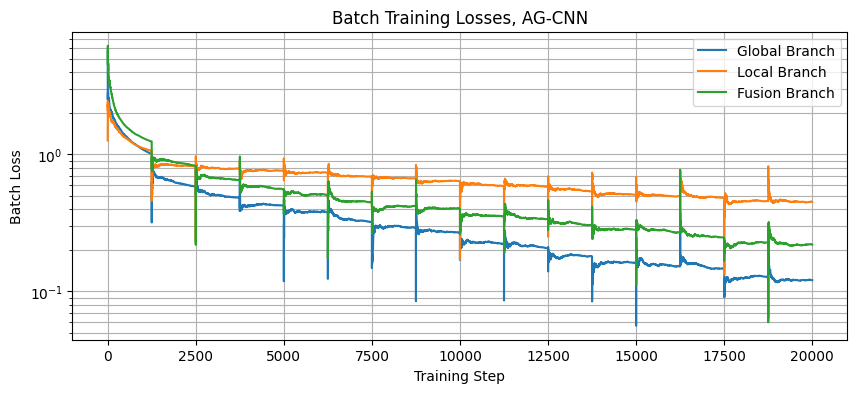

In [ ]:
# Log plot of training batch losses
fig = plt.figure(figsize = (10, 4))
plt.plot(np.arange(len(g_loss_tracker)), g_loss_tracker, label = 'Global Branch')
plt.plot(np.arange(len(l_loss_tracker)), l_loss_tracker, label = 'Local Branch')
plt.plot(np.arange(len(f_loss_tracker)), f_loss_tracker, label = 'Fusion Branch')
plt.semilogy()
plt.title('Batch Training Losses, AG-CNN')
plt.xlabel('Training Step')
plt.ylabel('Batch Loss')
plt.legend()
plt.grid(True, which="both")
plt.savefig('/content/drive/MyDrive/AG_CNN_Batch_Losses.pdf', bbox_inches = 'tight')

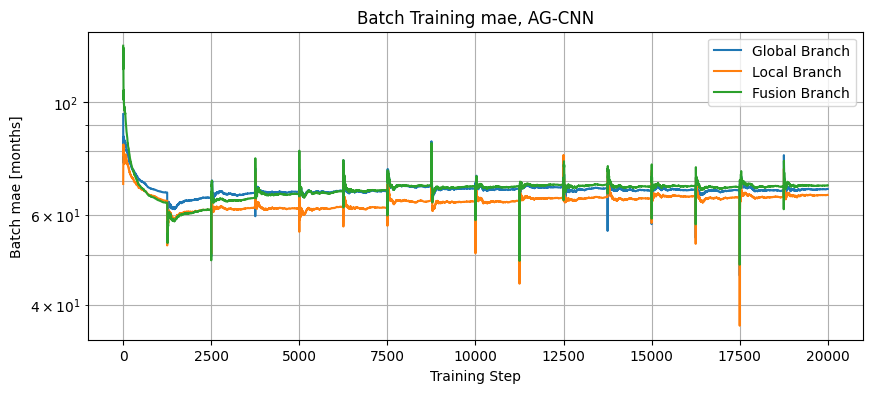

In [ ]:
# Log plot of training batch mae
fig = plt.figure(figsize = (10, 4))
plt.plot(np.arange(len(g_mae_tracker)), g_mae_tracker, label = 'Global Branch')
plt.plot(np.arange(len(l_mae_tracker)), l_mae_tracker, label = 'Local Branch')
plt.plot(np.arange(len(f_mae_tracker)), f_mae_tracker, label = 'Fusion Branch')
plt.semilogy()
plt.title('Batch Training mae, AG-CNN')
plt.xlabel('Training Step')
plt.ylabel('Batch mae [months]')
plt.legend()
plt.grid(True, which="both")
plt.savefig('/content/drive/MyDrive/AG_CNN_Batch_mae.pdf', bbox_inches = 'tight')

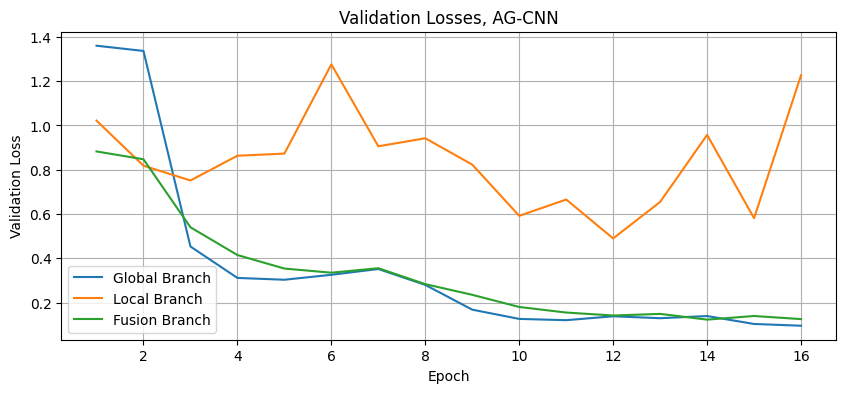

In [ ]:
# Plot of validation losses
fig = plt.figure(figsize = (10, 4))
plt.plot(np.arange(len(g_val_loss_tracker)), g_val_loss_tracker, label = 'Global Branch')
plt.plot(np.arange(len(l_val_loss_tracker)), l_val_loss_tracker, label = 'Local Branch')
plt.plot(np.arange(len(f_val_loss_tracker)), f_val_loss_tracker, label = 'Fusion Branch')
plt.title('Validation Losses, AG-CNN')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True, which="both")
plt.savefig('/content/drive/MyDrive/AG_CNN_Validation_Loss.pdf', bbox_inches = 'tight')

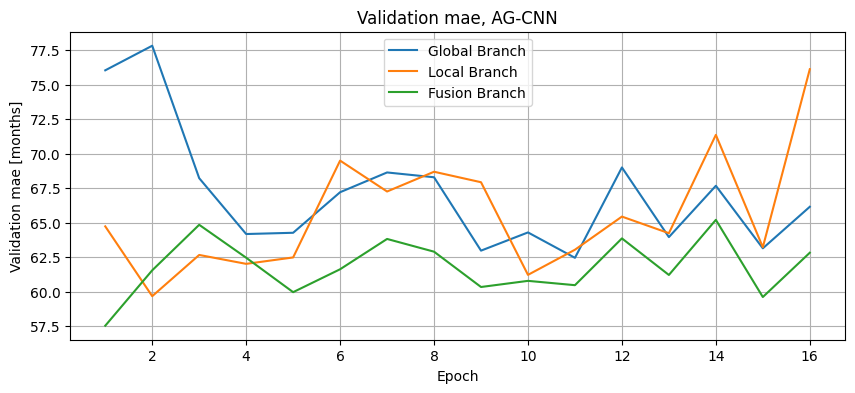

In [ ]:
# Plot of validation mae
fig = plt.figure(figsize = (10, 4))
plt.plot(np.arange(len(g_val_mae_tracker))+1, g_val_mae_tracker, label = 'Global Branch')
plt.plot(np.arange(len(l_val_mae_tracker))+1, l_val_mae_tracker, label = 'Local Branch')
plt.plot(np.arange(len(f_val_mae_tracker))+1, f_val_mae_tracker, label = 'Fusion Branch')
plt.title('Validation mae, AG-CNN')
plt.xlabel('Epoch')
plt.ylabel('Validation mae [months]')
plt.legend()
plt.grid(True, which="both")
plt.savefig('/content/drive/MyDrive/AG_CNN_Validation_mae.pdf', bbox_inches = 'tight')

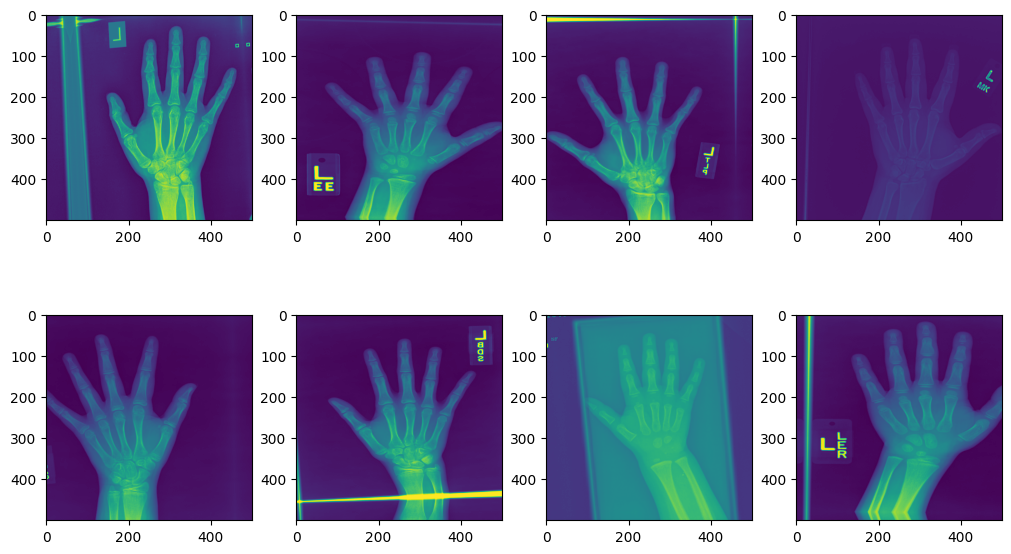

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 6), layout='constrained')
for ax, img in zip(axs.flat, val_inputs['Images']):
    ax.imshow(img)

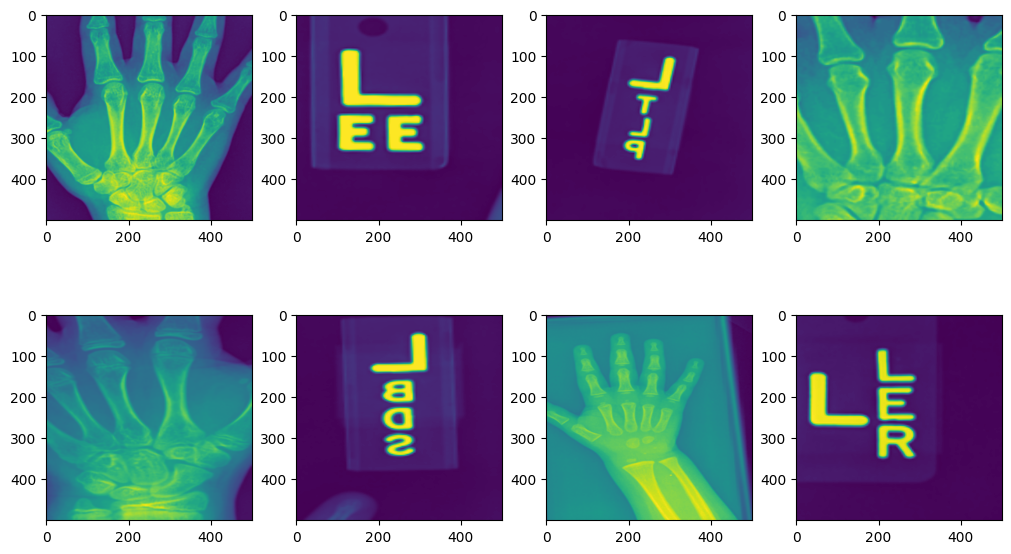

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 6), layout='constrained')
for ax, img in zip(axs.flat, attention_images):
    ax.imshow(img)

## Test

In [ ]:
!cp '/content/drive/MyDrive/Global_Branch_Best.keras' '/content/'
!cp '/content/drive/MyDrive/Local_Branch_Best.keras' '/content/'
!cp '/content/drive/MyDrive/Fusion_Branch_Best.keras' '/content/'

In [ ]:
trained_global_branch = tf.keras.models.load_model('/content/Global_Branch_Best.keras')
trained_local_branch = tf.keras.models.load_model('/content/Local_Branch_Best.keras')
trained_fusion_branch = tf.keras.models.load_model('/content/Fusion_Branch_Best.keras')

In [ ]:
# Instantiate a loss function.
loss_fn = tf.keras.losses.MeanSquaredError()

g_test_loss_metric = tf.keras.metrics.Mean(name='Global_Branch_Test_Loss')
l_test_loss_metric = tf.keras.metrics.Mean(name='Local_Branch_Test_Loss')
f_test_loss_metric = tf.keras.metrics.Mean(name='Fusion_Branch_Test_Loss')

g_test_mae_metric = tf.keras.metrics.Mean(name='Global_Branch_Test_MAE')
l_test_mae_metric = tf.keras.metrics.Mean(name='Local_Branch_Test_MAE')
f_test_mae_metric = tf.keras.metrics.Mean(name='Fusion_Branch_Test_MAE')

In [ ]:
# Test step functions for each branch
@tf.function
def g_test_step(original_images, labels):

    g_test_predictions, g_test_fm_out, g_test_pool_out  = trained_global_branch(original_images, training=False)

    g_test_loss = loss_fn(g_test_predictions, labels)
    g_test_loss_metric(g_test_loss)

    g_test_mae = mae_months(labels, g_test_predictions, "Test")
    g_test_mae_metric(g_test_mae)

    return g_test_predictions, g_test_fm_out, g_test_pool_out, g_test_loss_metric.result(), g_test_mae_metric.result()

@tf.function
def l_test_step(attention_images, labels):

    l_test_predictions, _, l_test_pool_out = trained_local_branch(attention_images, training=False)

    l_test_loss = loss_fn(l_test_predictions, labels)
    l_test_loss_metric(l_test_loss)

    l_test_mae = mae_months(labels, l_test_predictions, "Test")
    l_test_mae_metric(l_test_mae)

    return l_test_predictions, l_test_pool_out, l_test_loss_metric.result(), l_test_mae_metric.result()

@tf.function
def f_test_step(global_pool, local_pool, sex, labels):

    f_test_predictions = trained_fusion_branch({'Global_Branch_Pool_Output': global_pool, 'Local_Branch_Pool_Output': local_pool, 'Sex': sex}, training=False)

    f_test_loss = loss_fn(f_test_predictions, labels)
    f_test_loss_metric(f_test_loss)

    f_test_mae = mae_months(labels, f_test_predictions, "Test")
    f_test_mae_metric(f_test_mae)

    return f_test_predictions, f_test_loss_metric.result(), f_test_mae_metric.result()

In [ ]:
test_gt_tracker = []
test_g_pred_tracker = []
test_l_pred_tracker = []
test_f_pred_tracker = []

g_test_loss_metric.reset_states()
l_test_loss_metric.reset_states()
f_test_loss_metric.reset_states()

g_test_mae_metric.reset_states()
l_test_mae_metric.reset_states()
f_test_mae_metric.reset_states()

for test_inputs, test_labels in test_generator:
    g_test_pred, g_test_fm_out, g_test_pool_out, g_test_loss, g_test_mae = g_test_step(test_inputs['Images'], test_labels)
    attention_images = Attention_Mask_Inference(test_inputs['Images'], g_test_fm_out.numpy())
    l_test_pred, l_test_pool_out, l_test_loss, l_test_mae = l_test_step(attention_images, test_labels)
    f_test_pred, f_test_loss, f_test_mae = f_test_step(g_test_pool_out, l_test_pool_out, test_inputs['Sex'], test_labels)

    test_gt_tracker.append(test_labels)
    test_g_pred_tracker.append(g_test_pred)
    test_l_pred_tracker.append(l_test_pred)
    test_f_pred_tracker.append(f_test_pred)

print('The global branch loss on the test set is: ', g_test_loss_metric.result().numpy())
print('The global branch mae month on the test set is: ', g_test_mae_metric.result().numpy())
print('\nThe local branch loss on the test set is: ', l_test_loss_metric.result().numpy())
print('The local branch mae month on the test set is: ', l_test_mae_metric.result().numpy())
print('\nThe fusion branch loss on the test set is: ', f_test_loss_metric.result().numpy())
print('The fusion branch mae month on the test set is: ', f_test_mae_metric.result().numpy())

The global branch loss on the test set is:  0.18815021
The global branch mae month on the test set is:  64.29783

The local branch loss on the test set is:  0.79728854
The local branch mae month on the test set is:  61.391125

The fusion branch loss on the test set is:  0.2244653
The fusion branch mae month on the test set is:  62.65542


In [ ]:
#flattening all predictions and ground truth
flattened_gt = [element for subarray in test_gt_tracker for element in subarray]
flattened_g = [item for sublist1 in test_g_pred_tracker for sublist2 in sublist1 for item in sublist2]
flattened_l = [item for sublist1 in test_l_pred_tracker for sublist2 in sublist1 for item in sublist2]
flattened_f = [item for sublist1 in test_f_pred_tracker for sublist2 in sublist1 for item in sublist2]

#np.array version
flattened_gt = np.array(flattened_gt)
flattened_g =  np.array(flattened_g)
flattened_l =  np.array(flattened_l)
flattened_f =  np.array(flattened_f)

#normalized statistics
g_mse = np.mean(np.square(flattened_gt - flattened_g))
g_rmse = np.sqrt(np.mean((flattened_gt - flattened_g) ** 2))
g_P = np.corrcoef(flattened_gt, flattened_g)[0, 1]

l_mse = np.mean(np.square(flattened_gt - flattened_l))
l_rmse = np.sqrt(np.mean((flattened_gt - flattened_l) ** 2))
l_P = np.corrcoef(flattened_gt, flattened_l)[0, 1]

f_mse = np.mean(np.square(flattened_gt - flattened_f))
f_rmse = np.sqrt(np.mean((flattened_gt - flattened_f) ** 2))
f_P = np.corrcoef(flattened_gt, flattened_f)[0, 1]
print("MSE per Global model:", g_mse, "\n RMSE:", g_rmse, "\n correlation coefficient:", g_P)
print("MSE per Local  model:", l_mse, "\n RMSE:", l_rmse, "\n correlation coefficient:", l_P)
print("MSE per Fusion model:", f_mse, "\n RMSE:", f_rmse, "\n correlation coefficient:", f_P)

#Unnormalizing the prediction
flattened_gt = (flattened_gt*test_boneage_std) + test_boneage_mean
flattened_g =  (flattened_g*test_boneage_std) + test_boneage_mean
flattened_l = (flattened_l*test_boneage_std) + test_boneage_mean
flattened_f = (flattened_f*test_boneage_std) + test_boneage_mean

MSE per Global model: 0.18815022441605148 
 RMSE: 0.4337628665711848 
 correlation coefficient: 0.9102430187368085
MSE per Local  model: 0.7972886039251594 
 RMSE: 0.8929101880509369 
 correlation coefficient: 0.5766518789468255
MSE per Fusion model: 0.2244652934855173 
 RMSE: 0.47377768360858585 
 correlation coefficient: 0.8903501086625689


In [ ]:
# statistics with unnormalized values
g_mse = np.mean(np.square(flattened_gt - flattened_g))
g_rmse = np.sqrt(np.mean((flattened_gt - flattened_g) ** 2))
g_P = np.corrcoef(flattened_gt, flattened_g)[0, 1]

l_mse = np.mean(np.square(flattened_gt - flattened_l))
l_rmse = np.sqrt(np.mean((flattened_gt - flattened_l) ** 2))
l_P = np.corrcoef(flattened_gt, flattened_l)[0, 1]

f_mse = np.mean(np.square(flattened_gt - flattened_f))
f_rmse = np.sqrt(np.mean((flattened_gt - flattened_f) ** 2))
f_P = np.corrcoef(flattened_gt, flattened_f)[0, 1]
print("MSE per Global model:", g_mse, "\n RMSE:", g_rmse, "\n correlation coefficient:", g_P)
print("MSE per Local  model:", l_mse, "\n RMSE:", l_rmse, "\n correlation coefficient:", l_P)
print("MSE per Fusion model:", f_mse, "\n RMSE:", f_rmse, "\n correlation coefficient:", f_P)

MSE per Global model: 670.0495337041453 
 RMSE: 25.88531502037681 
 correlation coefficient: 0.9102430205451658
MSE per Local  model: 2839.342176627851 
 RMSE: 53.285478102648675 
 correlation coefficient: 0.5766518699468621
MSE per Fusion model: 799.376483360915 
 RMSE: 28.273246777844864 
 correlation coefficient: 0.8903501065942707


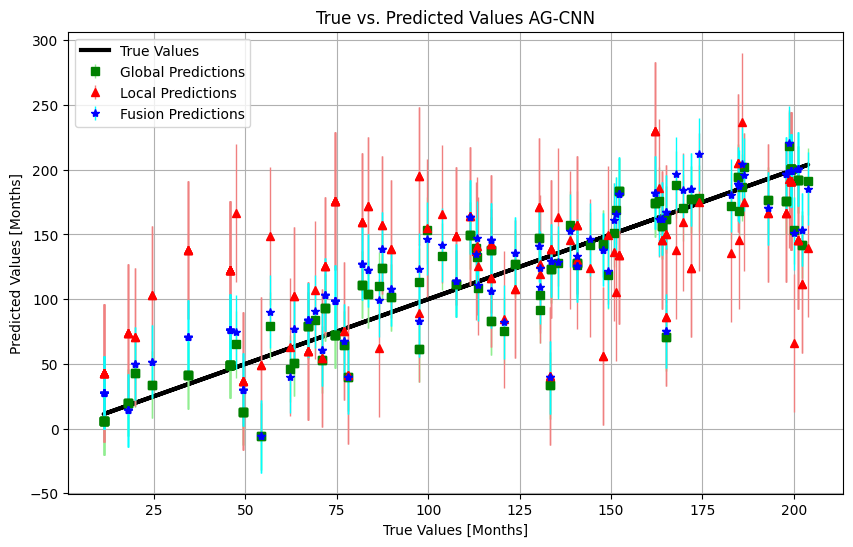

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(flattened_gt, flattened_gt, color='black', label='True Values', linewidth = 3)#, marker='o', s=30)

# Model 1 predictions in green
#plt.scatter(flattened_gt, flattened_g, color='green', label='Global Predictions', marker='s', s=30)
plt.errorbar(flattened_gt, flattened_g, yerr=g_rmse, fmt='s', color='green', ecolor='lightgreen', elinewidth=1, capsize=0, label='Global Predictions')

# Model 2 predictions in red
#plt.scatter(flattened_gt, flattened_l, color='red', label='Local Predictions', marker='^', s=30)
plt.errorbar(flattened_gt, flattened_l, yerr=l_rmse, fmt='^', color='red', ecolor='lightcoral', elinewidth=1, capsize=0, label='Local Predictions')

# Model 3 predictions in orange
#plt.scatter(flattened_gt, flattened_f, color='orange', label='Fusion Predictions', marker='x', s=30)
plt.errorbar(flattened_gt, flattened_f, yerr=f_rmse, fmt='*', color='blue', ecolor='cyan', elinewidth=1, capsize=0, label='Fusion Predictions')

# Ensemble predictions in purple
#plt.scatter(labels_sort, ensemble_preds, color='purple', label='Ensemble Predictions', marker='*', s=30)

# Add labels and legend
plt.xlabel("True Values [Months]")
plt.ylabel("Predicted Values [Months]")
plt.title("True vs. Predicted Values AG-CNN")
plt.legend(loc='best')

# Show the plot
plt.grid(True)
plt.show()